# Checkpoint 1

Implement here your algorithm to interpolate/extrapolate the activation time field from timings recorded in the 20 electrodes of the mapping catheter.

The algorithm should output the following information:
- a reconstruction of the activation times evaluated at each point of a structured grid on the square (-1.5, 1.5)x(-1.5, 1.5),
- an approximation of the conduction velocity (a clinical biomarker) evaluated at each point of a structured grid on the same square.


In [37]:
# imports

import numpy as np
import matplotlib.pyplot as plt

In [38]:
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project1/Cp1

Cloning into 'ScientificTools'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 132 (delta 37), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (132/132), 2.18 MiB | 12.39 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/ScientificTools/Project1/Cp1/ScientificTools/Project1/Cp1


In [39]:
# loading of the dataset

CP1data = np.load("CP1data.npz")
CP1data = CP1data['arr_0']
len(CP1data)

100

# Display one recording

In [146]:
ind_disp = 99
x_meas = CP1data[ind_disp][0]
y_meas = CP1data[ind_disp][1]
t_meas = CP1data[ind_disp][2]

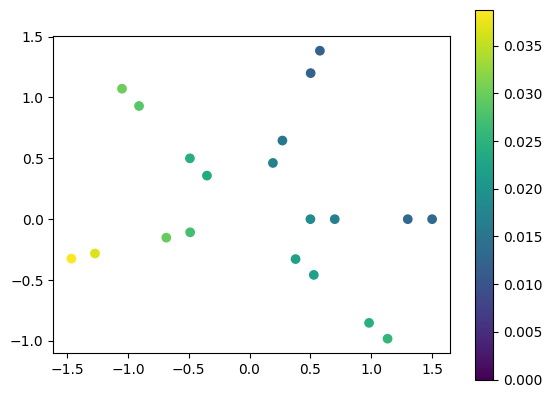

In [41]:
# Display a sample

plt.figure(1)
plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(t_meas) )
plt.gca().set_aspect(1)
plt.colorbar()

In [42]:
from scipy.interpolate import griddata

X, Y = np.meshgrid(np.linspace(-1.5,1.5,1501), np.linspace(-1.5,1.5,1501))


# signature of the function

def checkpoint1_solution( x, y , t, X , Y ):

return time_pred,vel_pred



In [ ]:
from scipy.interpolate import griddata

X, Y = np.meshgrid(np.linspace(-1.5,1.5,1501), np.linspace(-1.5,1.5,1501))

def checkpoint1_solution( x, y , t, X , Y ):

    time_pred = griddata(list(zip(x, y)), t, (X, Y), method='nearest')

    grad_AT = np.gradient(time_pred)

    vel_pred = 1.0/( np.sqrt((grad_AT[0]/(3.0/1500))**2+(grad_AT[1]/(3.0/1500))**2) + 1e-4)

    return time_pred,vel_pred

time_pred,vel_pred = checkpoint1_solution( x_meas, y_meas , t_meas, X , Y )

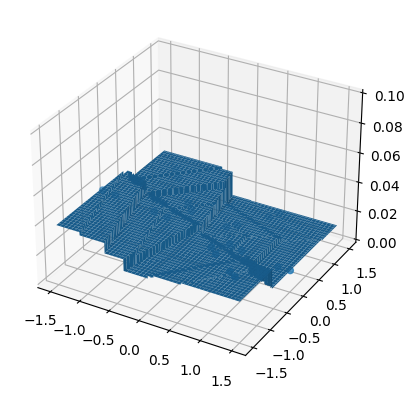

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,time_pred)
ax.axes.set_zlim3d(bottom=0, top=0.1)
ax.scatter3D(x_meas, y_meas, t_meas)

## **SPLINES**
A smoothing spline model for regression is a flexible non-parametric regression technique used for modeling the relationship between a response variable(time) and one or more predictor variables (position). It involves fitting a smooth curve to the observed data while penalizing roughness to avoid overfitting. λ is the smoothing parameter, a larger λ results in a smoother curve with less emphasis on fitting the data exactly. Since we have a small number of  observation (100) wer can exploit leave-one-out cross-validation (LOOCV) to choose an appropriate smoothing parameter.   

I choose splines of order 3 that means

*   polynomilas of order 2 at each interval
*   continuity at knots
-continuity of derivatives

-> so we can directly derive to get velocity conduction

**comments on the code**

splprep function is used to generate a B-spline representation for a curve in 3D space. tck: t is a knot vector, c is the coefficients of the B-spline (x, y, t_meas), and k is the degree of the spline.
splev([X, Y], tck)-> points_pred is a list containing three arrays:
The first array corresponds to the x-coordinates of the mesh points.
The second array corresponds to the y-coordinates of the mesh points.
The third array corresponds to the interpolated time predictions for each point (x, y) in the mesh.

In [ ]:
from scipy.interpolate import splprep, splev

def checkpoint1_solution(x, y, t, X, Y, s_value):
    # Create a B-spline representation of the data
    tck, u = splprep([x, y, t], s=s_value, per=False, k=3)

    # Evaluate the B-spline on the grid
    points_pred = splev([X.ravel(), Y.ravel()], tck)

    # Extract the activation time predictions
    time_pred = points_pred[2].reshape(1,1501,1501) # QUA è SBAGLIATO DOVREBBE RESTITUIRE UN TENSORE (1,1501,1501)

    # Compute the gradient of activation time using the B-spline derivatives
    grad_AT = splev((X, Y), tck, der=1)

    vel_pred = 1.0/( np.sqrt((grad_AT[0]/(3.0/1500))**2+(grad_AT[1]/(3.0/1500))**2) + 1e-4)
    return time_pred, vel_pred



In [ ]:
time_pred,vel_pred = checkpoint1_solution(x_meas, y_meas, t_meas, X, Y, 0)

ValueError: cannot reshape array of size 4506002 into shape (1,1501,1501)

NameError: name 'time_pred' is not defined

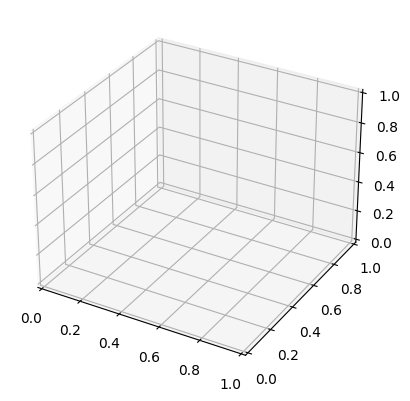

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,time_pred)
ax.axes.set_zlim3d(bottom=0, top=0.1)

In [ ]:
best_s_values = []  # List to store best s values for each observation
s_values=[0.1,0.2,0.3,0.4]

for index in range(100):
    x_obs = CP1data[index][0]
    y_obs = CP1data[index][1]
    t_obs = CP1data[index][2]

    best_s = None #is gonna keep track of each observation best parameter
    best_metric = float('inf')

    for s_value in s_values:
        total_mse = 0.0

        for i in range(20):
            x_train = np.delete(x_obs, i)
            y_train = np.delete(y_obs, i)
            t_train = np.delete(t_obs, i)

            x_val = x_obs[i]
            y_val = y_obs[i]
            t_val = t_obs[i]

            time_pred_val, _ = checkpoint1_solution(x_train, y_train, t_train, X, Y, s_value)


            mse = ((time_pred_val - t_val)**2).mean()
            total_mse += mse

        avg_mse = total_mse / 20  # Average over all LOOCV folds

        # Update best_s if the current s_value is better
        if avg_mse < best_metric:
            best_metric = avg_mse
            best_s = s_value

    best_s_values.append(best_s)



In [ ]:
final_best_s = np.mean(best_s_values)
final_best_s

0.26899999999999996

## **Splines updated**
We use bisplrep and bisplev to interpolate a 3D surface, kx and ky are the degree of the splines in the x and y axis respectively.

In [220]:
from scipy.interpolate import bisplrep, bisplev

def checkpoint1_solution(x, y, t, X, Y, s_value):
    # Create a B-spline representation of the data
    tck = bisplrep(x, y, t, s=s_value, kx=2, ky=2)

    # Evaluate the B-spline on the grid
    points_pred = bisplev(X[0, :], Y[:, 0], tck)

    # Extract the activation time predictions
    time_pred = points_pred

    # Compute the gradient of activation time using the B-spline derivatives
    grad_x = bisplev(X[0, :], Y[:, 0], tck, dx=1, dy=0)
    grad_y = bisplev(X[0, :], Y[:, 0], tck, dx=0, dy=1)

    vel_pred = 1.0/( np.sqrt((grad_x/(3.0/1500))**2+(grad_y/(3.0/1500))**2) + 1e-4)
    return time_pred, vel_pred

In [259]:
time_pred,vel_pred = checkpoint1_solution(x_meas, y_meas, t_meas, X, Y, 25)

(0.0, 0.1)

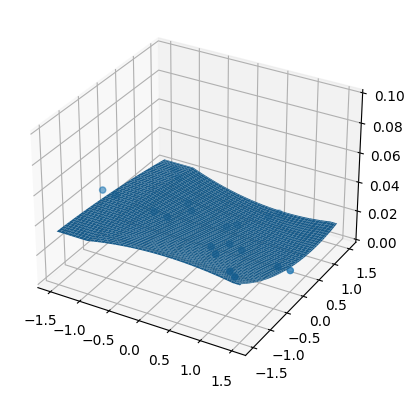

In [195]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,time_pred)
ax.scatter3D(x_meas, y_meas, t_meas)
ax.axes.set_zlim3d(bottom=0, top=0.1)

(0.0, 1.0)

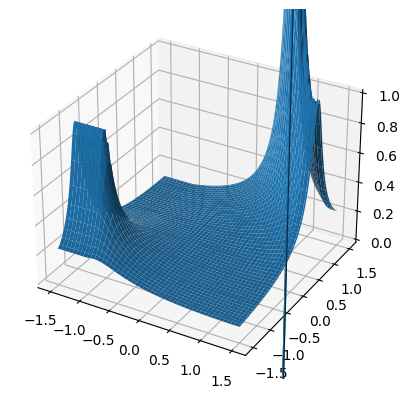

In [170]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,vel_pred)
ax.axes.set_zlim3d(bottom=0, top=1)

In [261]:
num_rows = time_pred.shape[0] #need to swap the rows of the matrix of times if we want to use imshow matching the values of the time with the right (X,Y)
for i in range(num_rows // 2):
    time_pred[i], time_pred[num_rows - 1 - i] = time_pred[num_rows - 1 - i], time_pred[i].copy()

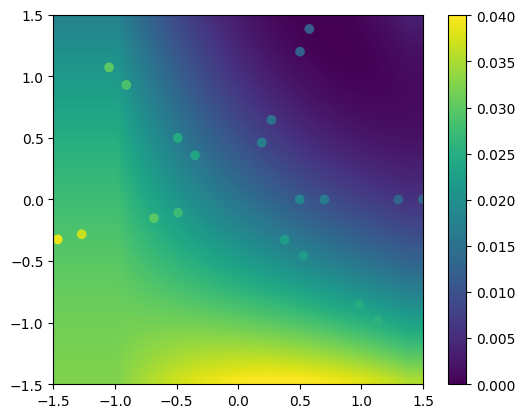

In [263]:
# Display a sample


plt.figure(1)
plt.imshow(time_pred, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)])
plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(time_pred))
plt.gca().set_aspect(1)
plt.colorbar()